In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split


model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [2]:
import optuna
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


def objective(trial):
    hidden_layer_sizes = [trial.suggest_int('n_units1', 2, 500),
                          trial.suggest_int('n_units2', 1, 500)]
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    alpha = trial.suggest_float('alpha', 1e-7, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True)
    

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=10000,
        solver='adam',
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)

    return mse

study = optuna.create_study(direction='minimize') 
improvement_threshold = 0.001
stale_count = 0

best_mse = float('inf')

mse_values = []

for _ in range(5000):
    study.optimize(objective, n_trials=1)

    if study.best_value < best_mse:
        best_mse = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    mse_values.append(best_mse)

    if stale_count >= 100 or best_mse <= improvement_threshold:  
        break

best_params = study.best_params
best_mse = study.best_value

print("Best Parameters:", best_params)
print("Best Mean Squared Error:", best_mse)


[I 2023-11-27 21:01:32,618] A new study created in memory with name: no-name-9d7abc4e-93fe-4db2-9ba8-51ccf1bcbf9e
[I 2023-11-27 21:01:47,725] Trial 0 finished with value: 323.2529914420708 and parameters: {'n_units1': 117, 'n_units2': 46, 'activation': 'relu', 'alpha': 0.0007186057624990909, 'learning_rate_init': 0.00019101402122354404}. Best is trial 0 with value: 323.2529914420708.
[I 2023-11-27 21:02:06,275] Trial 1 finished with value: 300.96113798595707 and parameters: {'n_units1': 143, 'n_units2': 334, 'activation': 'tanh', 'alpha': 0.0531233384857283, 'learning_rate_init': 0.000284179264846472}. Best is trial 1 with value: 300.96113798595707.
[I 2023-11-27 21:02:33,055] Trial 2 finished with value: 334.11185696685646 and parameters: {'n_units1': 384, 'n_units2': 275, 'activation': 'relu', 'alpha': 3.5609370749306106e-07, 'learning_rate_init': 0.0003941387130137306}. Best is trial 1 with value: 300.96113798595707.
[I 2023-11-27 21:04:39,600] Trial 3 finished with value: 245.44519

Średni błąd kwadratowy (MSE): 50.26361966807666
Procentowa zgodność: -24.79%


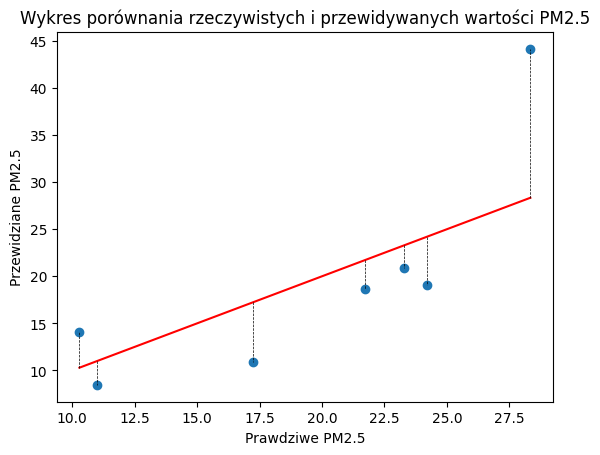

,Rzeczywiste wartości (y_test),Przewidywane wartości (y_pred),Różnica
0,10.29,14.103119,-3.813119
1,21.73,18.675734,3.054266
2,23.28,20.874816,2.405184
3,24.19,19.120477,5.069523
4,10.98,8.459472,2.520528
5,17.23,10.892921,6.337079
6,28.34,44.150766,-15.810766


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
model = MLPRegressor(**best_params, random_state=42, max_iter=10000)
model.fit(X_train_scaled, y_train)


# Model evaluation on the test set
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
percent_match = r2 * 100
print(f"Percentage Match (R^2): {percent_match:.2f}%")

# Visualization of predictions vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]],'k--', lw=0.1)
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Comparison of True and Predicted PM2.5 Values")
plt.show()

# Additional test data evaluation
model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenie", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']

X_test_test_scaled = scaler.transform(X_test_test)

y_pred_test = model.predict(X_test_test)
mse_test = mean_squared_error(y_test_test, y_pred_test)
r2_test = r2_score(y_test_test, y_pred_test)

print(f"Mean Squared Error (MSE) on additional test data: {mse_test}")
percent_match_test = r2_test * 100
print(f"R^2 score on additional test data: {percent_match_test:.2f}%")

# Visualization of additional test data predictions vs. actual values
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)], 'b', label='y=x')
plt.scatter(y_test_test, y_pred_test)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test[i]], 'k--', lw=0.5)
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Comparison of True and Predicted PM2.5 Values (Additional Test Data)")
plt.show()

In [7]:
model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002)

In [12]:

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test = model_data_test['PM2.5']


Średni błąd kwadratowy (MSE): 168.6452969535702
r2 score: -363.34%


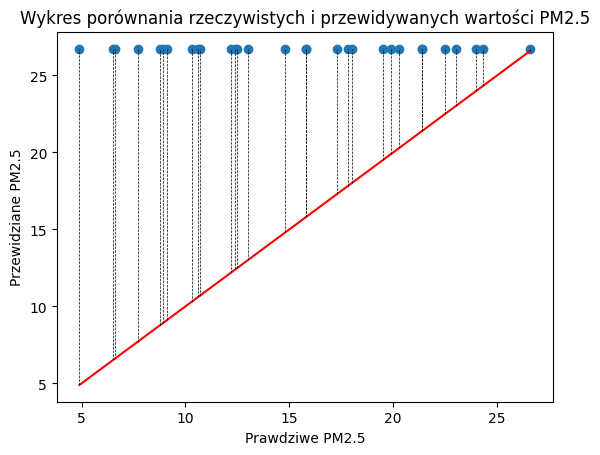

,Rzeczywiste wartości (y_test),Przewidywane wartości (y_pred),Różnica
0,9.1,26.7199,-17.6199
1,10.3,26.7199,-16.4199
2,12.4,26.7199,-14.3199
3,12.5,26.7199,-14.2199
4,15.8,26.7199,-10.9199
5,17.8,26.7199,-8.9199
6,23.0,26.7199,-3.7199
7,21.4,26.7199,-5.3199
8,24.0,26.7199,-2.7199
9,22.5,26.7199,-4.2199


In [16]:
model = MLPRegressor(max_iter=10000,hidden_layer_sizes=[427,5],activation='logistic',alpha= 1.1646563290242314e-07,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)']
results